In [1]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

dl = DataLib("SignalData")

In [204]:
'''
takes in indicator. Then processes return and plots bond return, indicator, and pnl
indicator is a function, returns new time series with the indicator

CURRENTLY ONLY DOING FOR USA
'''
bond_return_index = dl.pull('BondRetIdx/LocalFX')
bond_return_change = bond_return_index.resample('M').mean().pct_change()


def evaluate_performance(indicator):
    first_date = indicator.first_valid_index()
#     shifted_bond_return = bond_return_change.shift(-1)
    shifted_indicator = indicator.shift(1)
    days_profit = bond_return_change['USA'] * shifted_indicator
    days_profit += 1
    days_profit[first_date] = bond_return_index['USA'][first_date]
    pnl = days_profit.cumprod()
    return pnl
    
    
def plot_evaluation(indicator, pnl, plot_indicator = True):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(pnl.to_timestamp(), label = 'Portfolio Returns')
    ax1.plot(bond_return_index['USA'].to_timestamp(), label = 'Bond Market Index')
    ax1.set_ylabel('Returns Index')
    ax1.legend()
    if plot_indicator:
        ax2.plot(indicator.to_timestamp(), color = 'tab:red',label = 'Indicator')
        ax2.set_ylabel('Indicator')
        ax2.legend(loc = 'lower right')
    plt.title('USA portfolio performance vs bond market')
    plt.show()
    std_portfolio_pct_change = pnl.pct_change().std()
    std_market_pct_change = bond_return_index['USA'].resample('M').mean().pct_change().std()
    vol_adjusted_pnl = pnl * std_market_pct_change / std_portfolio_pct_change
    vol_adjusted_pnl.plot(label = 'vol adjusted portfolio returns')
    bond_return_index['USA'].plot(label = 'bond market returns')
    plt.legend()
    plt.ylabel('returns')
    plt.xlabel('date')
    plt.title('USA bond market returns index vs vol adjusted portfolio returns index')
    plt.show()

    

country  DEU       CAN  ESP       FRA       ITA       JPN  CHE  GBR       USA
date                                                                         
1980-01  NaN       NaN  NaN       NaN       NaN       NaN  NaN  NaN       NaN
1980-02  NaN  0.027795  NaN -0.009873 -0.004106 -0.035706  NaN  NaN  0.008026
1980-03  NaN -0.020369  NaN -0.066273 -0.060768  0.007787  NaN  NaN  0.003479
1980-04  NaN  0.016702  NaN  0.066250  0.079735  0.053850  NaN  NaN  0.001600
1980-05  NaN  0.028894  NaN  0.018842  0.022719  0.077458  NaN  NaN  0.006723
country  AUS       DEU  CAN  ESP  FRA  ITA  JPN  CHE       GBR       USA
date                                                                    
1980-01  NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN
1980-02  NaN -0.015638  NaN  NaN  NaN  NaN  NaN  NaN  0.011068 -0.077781
1980-03  NaN -0.056285  NaN  NaN  NaN  NaN  NaN  NaN  0.009164 -0.010159
1980-04  NaN  0.008272  NaN  NaN  NaN  NaN  NaN  NaN  0.048784  0.079100
1980-05  NaN  0.

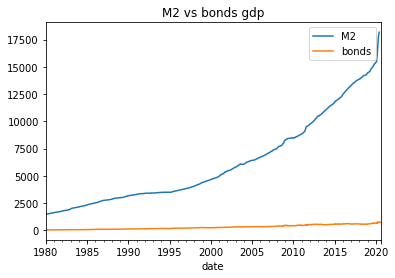

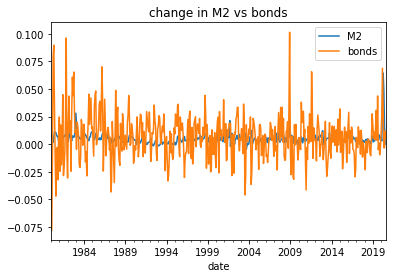

correlation:  0.12698813491300281


In [13]:
m1 = dl.pull('M1/inUSD') #monthly
m2 = dl.pull('M2/inUSD') 
m3 = dl.pull('M3/inUSD') 
change_in_m2 = m2.pct_change()
bond_return_index = dl.pull('BondRetIdx/LocalFX')
change_in_bonds = bond_return_index.resample('M').mean().pct_change()
# change_in_bonds = bond_return_index.pct_change()
print(change_in_m2.head())
print(change_in_bonds.head())

m2['USA'].plot()
bond_return_index['USA'].plot()
plt.title('M2 vs bonds gdp')
plt.legend(['M2', 'bonds'])
plt.show()

change_in_m2['USA'].plot()
change_in_bonds['USA'].plot()
plt.title('change in M2 vs bonds')
plt.legend(['M2', 'bonds'])
plt.show()

print('correlation: ', change_in_bonds['USA'].corr(change_in_m2['USA']))


from a very preliminary look, change in monetary base seems to be a better indicator than change in equities so I will continue looking into monetary basis as an indicator.

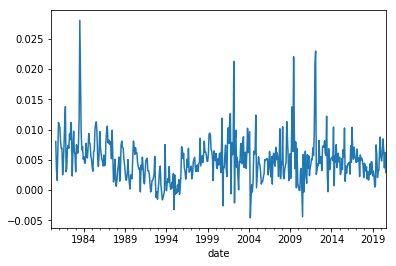

correlation:  -0.07459879902995842


In [36]:
rolling_change_m2 = change_in_m2.rolling(1).mean()
rolling_change_m2 = rolling_change_m2.shift(6)
rolling_change_m2['USA'].plot()
plt.show()
print('correlation: ', change_in_bonds['USA'].corr(rolling_change_m2['USA']))

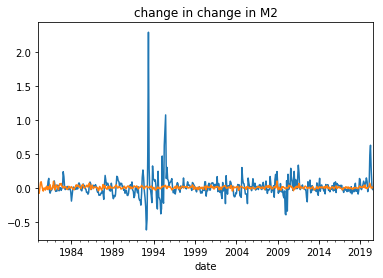

correlation:  0.07018887969280899


In [24]:
rolling_change_m2 = change_in_m2.rolling(12).mean()
change_change_in_m2 = rolling_change_m2.pct_change()
change_change_in_m2['USA'].plot()
change_in_bonds['USA'].plot()
plt.title('change in change in M2')
plt.show()
print('correlation: ', change_in_bonds['USA'].corr(change_change_in_m2['USA']))

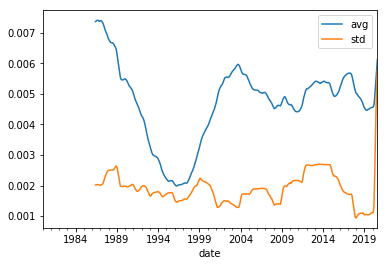

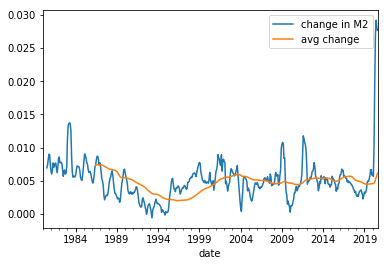

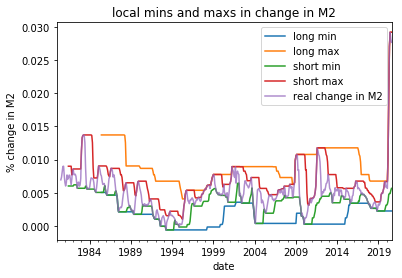

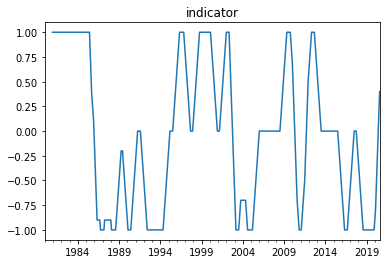

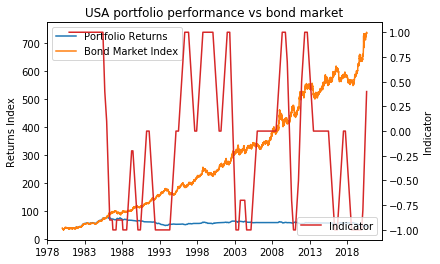

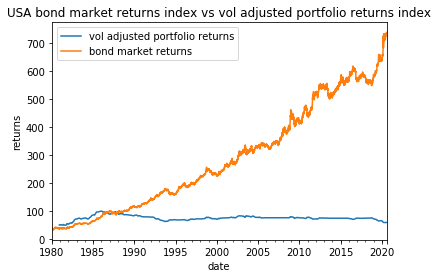

max return:  76.08424458368297


In [206]:
'''
trying to capture where we are in short term business cycle to understand if we are in a period of deflation
which is usually cooupled with a fall of interest rates or in a periof of inflation which is usually coupled with 
a rise of interest rates
'''

mins_and_maxs = pd.Series([])
change_in_m2 = m2.pct_change() #monthly
change_in_m2 = change_in_m2.rolling(6).mean()
country = 'USA'



# STD Z-Score way to caluclate
avg_change_in_m2 = change_in_m2.rolling(12 * 6).mean()
std_change_in_m2 = change_in_m2.rolling(12 * 6).std()
avg_change_in_m2[country].plot(label = 'avg')
std_change_in_m2[country].plot(label = 'std')
plt.legend()
plt.show()

   
change_in_m2[country].plot(label = 'change in M2')
avg_change_in_m2[country].plot(label = 'avg change')
plt.legend()
plt.show()
    

# Find local peaks
# try to find trough of short term business cycle (length = 5yrs)
mins_and_maxs['long_local_min'] = change_in_m2[country].rolling(12*5).min()
# find local min to compare and see if we are nearing or at a trough (used rolling 
# 12 months because very volatile and I didnt want the small bumps to affect where 
# I thoguht I was in the business cycle)
mins_and_maxs['short_local_min'] = change_in_m2[country].rolling(12).min()
# find peak of short term business cycle 
mins_and_maxs['long_local_max'] = change_in_m2[country].rolling(12*5).max()
# find 1 yr local max and compare to peak
mins_and_maxs['short_local_max'] = change_in_m2[country].rolling(12).max()

mins_and_maxs['long_local_min'].plot(label = 'long min')
mins_and_maxs['long_local_max'].plot(label = 'long max')
mins_and_maxs['short_local_min'].plot(label = 'short min')
mins_and_maxs['short_local_max'].plot(label = 'short max')
change_in_m2[country].plot(label = 'real change in M2', alpha = 0.75)
plt.title('local mins and maxs in change in M2')
plt.ylabel('% change in M2')
plt.xlabel('date')
plt.legend()
plt.show()

for date in change_in_m2.index:
    # indicator to check where we are in short term business cycle
    val = 0.05 if mins_and_maxs['short_local_min'][date] == mins_and_maxs['long_local_min'][date] else -0.05
    val += 0.05 if mins_and_maxs['short_local_max'][date] < mins_and_maxs['long_local_max'][date] else -0.05
    m2_indicator.loc[date] = val

# m2_indicator = -(change_in_m2[country] - avg_change_in_m2[country]) / std_change_in_m2[country]
    
m2_indicator = m2_indicator.rolling(12).sum()
m2_indicator = -m2_indicator.clip(-1,1)

m2_indicator.plot()
plt.title('indicator')
plt.show()

pnl = evaluate_performance(m2_indicator)
plot_evaluation(m2_indicator, pnl)
print('max return: ', pnl.max())


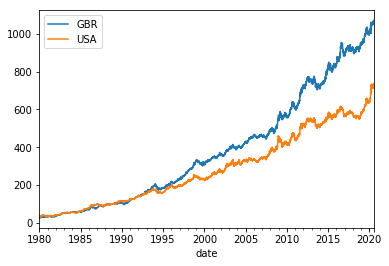

In [115]:
bond_return_index['GBR'].plot(label = 'GBR')
bond_return_index['USA'].plot(label = 'USA')
plt.legend()
plt.show()